In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import datetime

In [2]:
df_2020 = pd.read_csv('../data/richmond_apparatus_data.csv')
df_2019 = pd.read_csv('../data/richmond_apparatus_data_2019.csv')

In [3]:
df = pd.concat([df_2019, df_2020]).reset_index()

In [4]:
df = df.dropna(subset=['apparatus_data.unit_status.arrived.timestamp'])

In [5]:
df = df[pd.to_datetime(df['apparatus_data.unit_status.enroute.timestamp']) < pd.to_datetime(datetime.date(2021, 3, 1), utc=True)]

In [6]:
df['description.event_opened'] = pd.to_datetime(df['description.event_opened'])
df['date'] = df['description.event_opened'].progress_apply(lambda x: x.strftime('%Y-%m-%d'))

daily_counts = df.groupby(['date','description.type']).size().reset_index(name='count')
#daily_counts['sum_of_last_7_days'] = daily_counts.rolling(window=7).sum()
#daily_counts['day_of_week'] = daily_counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84884/84884 [00:00<00:00, 278409.55it/s]


In [7]:
lower_bound = pd.to_datetime(datetime.date(2021, 1, 3), utc=True)
upper_bound = pd.to_datetime(datetime.date(2021, 2, 5), utc=True)

mask = (pd.to_datetime(daily_counts['date']).dt.date > lower_bound) & (pd.to_datetime(daily_counts['date']).dt.date < upper_bound)

df_for_baseline = daily_counts.loc[mask]
df_for_baseline['day_of_the_week'] = df_for_baseline['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 19089.02it/s]


In [8]:
baseline_per_day = df_for_baseline.groupby(['day_of_the_week','description.type']).median()['count'].to_frame().reset_index()
baseline_per_day.columns = ['day_of_week','description.type', 'baseline_count']

In [9]:
baseline_per_day

,day_of_week,description.type,baseline_count
0,Friday,ASSIST-EMS,2.5
1,Friday,ASSIST-POLICE,1.0
2,Friday,CRASH,13.0
3,Friday,ELEVATOR,3.0
4,Friday,EMS-1STRESP,43.5
...,...,...,...
95,Wednesday,SMOKE-INVEST,2.0
96,Wednesday,STRUCTURE-FIRE,12.0
97,Wednesday,TRASH-FIRE,1.0
98,Wednesday,UTILITY-INCIDENT,4.5


In [10]:
baseline_per_day[baseline_per_day['description.type'] == 'CRASH']

,day_of_week,description.type,baseline_count
2,Friday,CRASH,13.0
15,Monday,CRASH,6.0
29,Saturday,CRASH,10.0
42,Sunday,CRASH,9.0
56,Thursday,CRASH,13.0
72,Tuesday,CRASH,9.0
87,Wednesday,CRASH,11.0


In [11]:
daily_counts['year'] = pd.DatetimeIndex(pd.to_datetime(daily_counts['date'], utc=True)).year
daily_counts['day'] = pd.DatetimeIndex(pd.to_datetime(daily_counts['date'], utc=True)).day
daily_counts['month'] = pd.DatetimeIndex(pd.to_datetime(daily_counts['date'], utc=True)).month
#daily_counts_2020 = daily_counts[daily_counts['year']==2020]
daily_counts['day_of_week'] = daily_counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7254/7254 [00:00<00:00, 21337.86it/s]


In [12]:
df_compare = pd.merge(daily_counts, baseline_per_day, on=['day_of_week','description.type'], how='inner').reset_index()
df_compare['change_from_baseline'] = (df_compare['count'] - df_compare['baseline_count'])/df_compare['baseline_count']*100

In [13]:
df_incident_baseline_change = df_compare[['date','change_from_baseline','description.type','day_of_week']]

In [14]:
df_2020_google = pd.read_csv('../data/google_data/2020_US_Region_Mobility_Report.csv')
df_virginia = df_2020_google[df_2020_google['sub_region_1'] == 'Virginia']
df_richmond = df_virginia[df_virginia['sub_region_2'] == 'Richmond County']

In [15]:


mobility_df = df_richmond[['date', 'workplaces_percent_change_from_baseline']]
mobility_df['avg_last_7_days'] = mobility_df['workplaces_percent_change_from_baseline'].rolling(window=7, min_periods=1).mean(skipna=True)
mobility_df['day_of_week'] = mobility_df['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 16527.82it/s]


In [16]:
#df_incident_baseline_change['avg_last_7_days'] = df_incident_baseline_change['change_from_baseline'].groupby('description.type').rolling(window=7, min_periods=1).mean(skipna=True)
#df_incident_baseline_change['day_of_week'] = df_incident_baseline_change['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
df_final = df_incident_baseline_change.groupby(['description.type','date']).rolling(window=7, min_periods=1).mean(skipna=True).reset_index()
df_final['day_of_week'] = df_final['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6147/6147 [00:00<00:00, 21562.97it/s]


In [17]:
first_day_of_week = 'Monday'
df_final = df_final[df_final['day_of_week']==first_day_of_week]

In [18]:
df_incident_baseline_change

,date,change_from_baseline,description.type,day_of_week
0,2018-12-31,-78.378378,EMS-1STRESP,Monday
1,2019-01-07,51.351351,EMS-1STRESP,Monday
2,2019-01-14,35.135135,EMS-1STRESP,Monday
3,2019-01-21,48.648649,EMS-1STRESP,Monday
4,2019-01-28,21.621622,EMS-1STRESP,Monday
...,...,...,...,...
6142,2021-01-17,0.000000,FIRE-STANDBY,Sunday
6143,2020-06-01,200.000000,FIRE-STANDBY,Monday
6144,2021-01-18,0.000000,FIRE-STANDBY,Monday
6145,2020-06-10,0.000000,FIRE-STANDBY,Wednesday


In [34]:
first_day_of_week = 'Monday'
weekly_incident_counts = daily_counts[daily_counts['day_of_week']==first_day_of_week]
weekly_incident_counts['date'] = pd.to_datetime(weekly_incident_counts['date'])
weekly_incident_counts = weekly_incident_counts.sort_values('date')
weekly_incident_change = df_incident_baseline_change[df_incident_baseline_change['day_of_week']==first_day_of_week]
weekly_incident_change['date'] = pd.to_datetime(weekly_incident_change['date'])

weekly_mobility = mobility_df[mobility_df['day_of_week']==first_day_of_week]
weekly_mobility['date'] = pd.to_datetime(weekly_mobility['date'])


In [35]:
grouped_df = df_final.groupby('description.type')
groups = list(grouped_df.groups.keys())

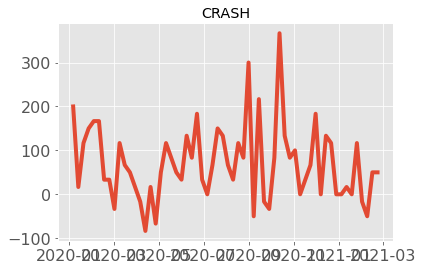

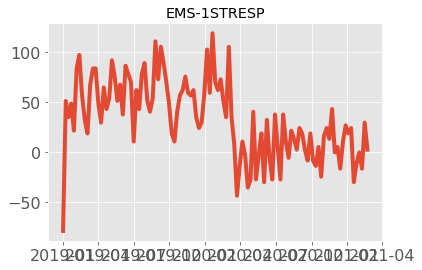

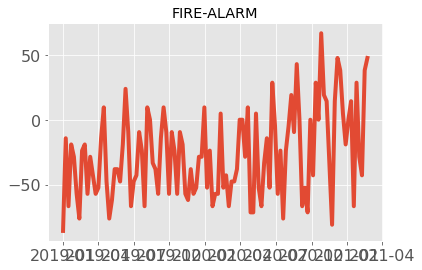

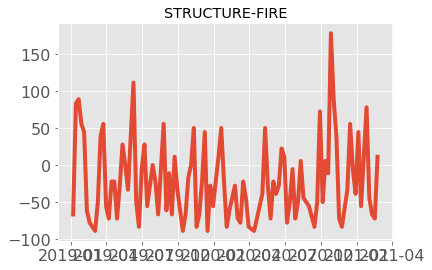

<Figure size 432x288 with 0 Axes>

In [36]:
for group in['CRASH','EMS-1STRESP','FIRE-ALARM','STRUCTURE-FIRE']:
    df_to_plot = grouped_df.get_group(group)
    plt.plot(pd.to_datetime(df_to_plot['date']),df_to_plot['change_from_baseline'])
    plt.title(group)
    plt.figure()

In [32]:
weekly_incident_change

,date,change_from_baseline,description.type,day_of_week
0,2018-12-31,-78.378378,EMS-1STRESP,Monday
1,2019-01-07,51.351351,EMS-1STRESP,Monday
2,2019-01-14,35.135135,EMS-1STRESP,Monday
3,2019-01-21,48.648649,EMS-1STRESP,Monday
4,2019-01-28,21.621622,EMS-1STRESP,Monday
...,...,...,...,...
6018,2021-02-08,-50.000000,CRASH,Monday
6019,2021-02-15,50.000000,CRASH,Monday
6020,2021-02-22,50.000000,CRASH,Monday
6143,2020-06-01,200.000000,FIRE-STANDBY,Monday


KeyError: 'avg_last_7_days'

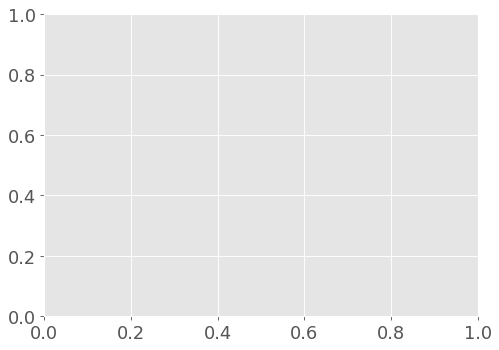

In [31]:
plt.figure(figsize=(7, 5), dpi=80)
ax1 = plt.subplot()
l1, = ax1.plot(weekly_incident_change['date'], weekly_incident_change['avg_last_7_days'], color='red');
ax1.scatter(df_incident_baseline_change['date'], df_incident_baseline_change['change_from_baseline'], color='red', alpha=.2);

ax1.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='x', rotation=70)
ax1.set_ylabel('incident count (NFORS)')
ax2 = ax1.twinx()
l2, = ax2.plot(weekly_mobility['date'], weekly_mobility['avg_last_7_days'], color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')
ax2.scatter(pd.to_datetime(df_richmond['date']) , df_richmond['workplaces_percent_change_from_baseline'], color='dodgerblue',alpha=.2)
ax2.set_ylabel('% change in workplace (google)')

ax1.grid(False)
ax2.grid(False)
plt.xlim(left=pd.to_datetime('2020-02-15'));


In [30]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(weekly_incident_change['date'], weekly_incident_change['avg_last_7_days'], color='red', label='incidents');
plt.scatter(df_incident_baseline_change['date'], df_incident_baseline_change['change_from_baseline'], color='red', alpha=.2);
plt.tick_params(axis='x', rotation=70)
plt.ylabel('percentage difference from baseline')
plt.plot(weekly_mobility['date'], weekly_mobility['avg_last_7_days'], color='dodgerblue', label='workplace mobility')
plt.scatter(pd.to_datetime(df_richmond['date']) , df_richmond['workplaces_percent_change_from_baseline'], color='dodgerblue',alpha=.2)

plt.grid(False)
plt.grid(False)
plt.ylim(-50, 50)
plt.legend()
plt.xlim(left=pd.to_datetime('2020-02-15'));

KeyError: 'avg_last_7_days'

<Figure size 560x400 with 0 Axes>

In [ ]:
df_new = pd.merge(weekly_mobility, weekly_incident_change, how='inner', on='date')
plt.scatter(df_new['avg_last_7_days_x'], df_new['avg_last_7_days_y'])

In [ ]:
df_new.corr()

In [ ]:
lower = poisson(mu = Lambda).ppf(0.025)
upper = poisson(mu = Lambda).ppf(1-0.025)

In [ ]:
plt.plot(X_matrix[:,1], X_matrix@theta_ML, alpha=.5)
plt.fill_between(X_matrix[:,1], np.log(lower), np.log(upper), alpha=0.5)
plt.scatter(X_matrix[:,1], np.log(Y_matrix),color='black')
plt.xlabel('mobility')
plt.ylabel('log(incident_count)');

In [ ]:
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta_ML), alpha=.5)
plt.fill_between(X_matrix[:,1], lower, upper, alpha=0.5)
plt.scatter(X_matrix[:,1], Y_matrix, color='black')
plt.xlabel('mobility')
plt.ylabel('incident_count');

In [ ]:
y_pred = np.exp(X_matrix@theta_ML)
plt.scatter(y_pred, Y_matrix)
lower = poisson.ppf(q=.025, mu=y_pred)
upper = poisson.ppf(q=.975, mu=y_pred)
plt.fill_between(y_pred, lower, upper, alpha=.5)
plt.ylabel('actual')
plt.xlabel('pred');

In [ ]:
#check it gives the same
from sklearn import linear_model
clf = linear_model.PoissonRegressor()
clf.fit(X_matrix[:,1].reshape(-1,1), Y_matrix.reshape(-1,1))
clf.coef_

In [ ]:
clf.intercept_

In [ ]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [ ]:
Y_matrix.reshape(-1,1).shape
#X_matrix.shape

In [ ]:
res = NegativeBinomial(Y_matrix, X_matrix).fit()

In [ ]:
theta = np.array([res.params[0], res.params[1]])
theta

In [ ]:
plt.scatter(X_matrix[:,1], Y_matrix)
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta))

In [ ]:
mu = np.exp(X_matrix@theta)
var = mu + mu**2 * res.params[2]

In [ ]:
from scipy.stats import nbinom

In [ ]:
p = mu/var
n = mu**2/(var-mu)

In [ ]:
lower = nbinom(p=p,n=n).ppf(0.025)
upper = nbinom(p=p,n=n).ppf(1-0.025)

In [ ]:
plt.scatter(X_matrix[:,1], Y_matrix)
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta))
plt.fill_between(X_matrix[:,1], lower, upper, alpha=.5)
#Much better!!